# AFL FantaPrediction

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 30)

### Step 1: Get Footywire Data

In [2]:
# Get footywire match data with a row for each player
df_footywire_data = pd.read_csv(r'inputs/footywire_player_matches.csv', index_col=0)
# Drop duplicates
df_footywire_data = df_footywire_data.drop_duplicates()
df_footywire_data

,Date,Season,Round,Venue,Player,Team,Opposition,Status,Match_id,CP,UP,ED,DE,CM,GA,MI5,One.Percenters,BO,TOG,K,HB,D,M,G,B,T,HO,GA1,I50,CL,CG,R50,FF,FA,AF,SC,CCL,SCL,SI,MG,TO,ITC,T5
1,2010-03-25,2010,Round 1,MCG,Daniel Connors,Richmond,Carlton,Home,5089,8,15,16,66.7,0,0,0,1,0,69,14,10,24,3,0,0,1,0,0,2,2,4,6,2,0,77,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-03-25,2010,Round 1,MCG,Daniel Jackson,Richmond,Carlton,Home,5089,11,10,14,60.9,1,0,0,0,0,80,11,12,23,2,0,0,5,0,0,8,5,4,1,2,0,85,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-03-25,2010,Round 1,MCG,Brett Deledio,Richmond,Carlton,Home,5089,7,14,16,76.2,0,0,0,0,0,89,12,9,21,5,1,0,6,0,0,4,3,4,3,1,2,94,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-03-25,2010,Round 1,MCG,Ben Cousins,Richmond,Carlton,Home,5089,9,10,11,57.9,0,1,0,0,0,69,13,6,19,1,1,0,1,0,1,1,2,3,4,1,0,65,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2010-03-25,2010,Round 1,MCG,Trent Cotchin,Richmond,Carlton,Home,5089,8,10,13,68.4,1,0,0,0,1,77,11,8,19,6,0,0,1,0,0,2,3,3,2,0,2,65,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90416,2019-09-28,2019,Grand Final,MCG,Harrison Himmelberg,GWS,Richmond,Away,9927,3,9,7,58.3,1,0,2,4,0,92,9,3,12,7,1,1,1,2,0,2,0,3,0,1,1,65,51,0.0,0.0,3.0,153.0,4.0,2.0,1.0
90417,2019-09-28,2019,Grand Final,MCG,Samuel Reid,GWS,Richmond,Away,9927,5,6,8,66.7,0,0,0,4,0,96,5,7,12,2,0,0,3,0,0,0,1,2,1,0,0,47,55,0.0,1.0,1.0,97.0,2.0,5.0,0.0
90418,2019-09-28,2019,Grand Final,MCG,Adam Kennedy,GWS,Richmond,Away,9927,4,8,9,81.8,0,0,0,1,0,71,5,6,11,4,0,0,4,0,0,2,1,0,0,1,0,56,55,0.0,1.0,1.0,121.0,0.0,5.0,1.0
90419,2019-09-28,2019,Grand Final,MCG,Shane Mumford,GWS,Richmond,Away,9927,8,2,7,70.0,0,0,0,4,0,75,2,8,10,0,0,0,1,15,0,1,2,2,1,1,0,42,62,1.0,1.0,0.0,0.0,1.0,2.0,0.0


In [3]:
# Get Fanfooty match data with a row for each player (including match notes and injury tags)
df_fanfooty_player_raw = pd.read_csv(r'inputs/fanfooty_raw.csv', low_memory=False)

# Identify when a player is injured
injured_tags = [
    'sore',
    'injured',
    'longterminjured',
    'concussed',
    'heart'
]

def get_injured_status(row):
    if (row['Tag'] in injured_tags or row['Tag 2'] in injured_tags) and row['SC'] < 80:
        return True
    else:
        return False

df_fanfooty_player_raw['Injured'] = df_fanfooty_player_raw.apply(lambda row: get_injured_status(row), axis=1)

# Create year, round, and player identifier to link with footywire data
df_fanfooty_player_raw['year_round_player_id'] = df_fanfooty_player_raw['Year'].astype(str) + "_" + df_fanfooty_player_raw['Round'].astype(str) + "_" + df_fanfooty_player_raw['Player ID'].astype(str)

df_fanfooty_player_raw

,Fanfooty Match ID,Round,Year,Player ID,First Name,Surname,Team,null,DT,SC,null2,null3,null4,Kicks,Handballs,Marks,Tackles,Hitouts,Frees for,Frees against,Goals,Behinds,Not sure,Tag,Tag Notes,Tag 2,Tag 2 Notes,null5,null6,null7,null8,Position,Jumper Number,null9,null10,null11,DT own %,SC own %,AF own %,null12,AF Breakeven,null13,Contested Possessions,Clearances,Clangers,Disposal efficiency,Time on ground,Injured,year_round_player_id
0,http://live.fanfooty.com.au/game/matchcentre.h...,R4,2010,990020,Andrew,Embley,WC,30,111,98.0,144,79,112,20,8,1,6,1,1,0,1,0,Full Time,gun,Dempsey going with him... %s from %O and %T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2010_R4_990020
1,http://live.fanfooty.com.au/game/matchcentre.h...,R4,2010,230254,Adam,Selwood,WC,50,107,107.0,143,79,108,10,9,4,11,0,3,2,1,0,Full Time,hot,Tagged by Lonergan... %D and %M with %T plus %s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2010_R4_230254
2,http://live.fanfooty.com.au/game/matchcentre.h...,R4,2010,200112,Dean,Cox,WC,27,99,118.0,114,88,106,9,10,2,2,30,4,1,1,1,Full Time,news,%H and %P with %s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2010_R4_200112
3,http://live.fanfooty.com.au/game/matchcentre.h...,R4,2010,240016,Beau,Waters,WC,26,98,84.0,130,79,117,15,13,5,6,0,0,4,0,0,Full Time,news,%P and %M with %F... clangers and FA dampening...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2010_R4_240016
4,http://live.fanfooty.com.au/game/matchcentre.h...,R4,2010,261911,Brad,Ebert,WC,26,94,109.0,121,70,96,12,9,3,6,0,1,0,1,0,Full Time,news,Matched up on Winderlich... %D and %T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2010_R4_261911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88570,http://live.fanfooty.com.au/game/matchcentre.h...,GF,2019,261374,Sam J.,Reid,WS,4,47,55.0,40,36,51,5,7,2,3,0,0,0,0,0,Full Time,utility,%D and %M with %T... Mostly in defence,NaN,NaN,0.0,NaN,0.0,NaN,Forward,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,5.0,1.0,2.0,66.0,96.0,False,2019_GF_261374
88571,http://live.fanfooty.com.au/game/matchcentre.h...,GF,2019,280762,Shane,Mumford,WS,8,42,62.0,38,38,48,2,8,0,1,15,1,0,0,0,Full Time,ruck,%O including %B... First ruck,NaN,NaN,0.0,NaN,0.0,NaN,Ruck,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,8.0,2.0,2.0,70.0,75.0,False,2019_GF_280762
88572,http://live.fanfooty.com.au/game/matchcentre.h...,GF,2019,290675,Daniel,Lloyd,WS,6,38,54.0,23,34,52,6,9,1,1,0,0,2,0,1,Full Time,wing,%D and %s... Playing a half forward role,NaN,NaN,0.0,NaN,0.0,NaN,Midfielder,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,8.0,2.0,4.0,66.0,76.0,False,2019_GF_290675
88573,http://live.fanfooty.com.au/game/matchcentre.h...,GF,2019,271015,Matthew,de Boer,WS,3,31,21.0,16,31,46,6,6,3,0,0,0,3,0,1,Full Time,tagger,%O and %M plus %s... not helped by %F... Doing...,NaN,NaN,0.0,NaN,0.0,NaN,Midfielder,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,6.0,66.0,79.0,False,2019_GF_271015


In [4]:
# Get player identification links (refer to footywire-player-ids jupyter notebook)
df_final_player_ids = pd.read_csv('Inputs/final_player_ids_08-02-20.csv')
df_final_player_ids['Player ID'] = df_final_player_ids['Player ID'].astype(str).replace('\.0', '', regex=True)
df_final_player_ids

,Unnamed: 0,Season,Team_footywire,Player,SC_footywire,season_team_name_id,Player ID,Year,Team_fanfooty,Full Name,SC_fanfooty,fuzzy_match_name,fuzzy_season_team_name
0,0,2011,North Melbourne,Aaron Black,33.000000,2011_North Melbourne_Aaron Black,291672,2011.0,North Melbourne,Aaron Black,33.000000,NaN,NaN
1,1,2012,North Melbourne,Aaron Black,49.666667,2012_North Melbourne_Aaron Black,291672,2012.0,North Melbourne,Aaron Black,49.666667,NaN,NaN
2,2,2013,North Melbourne,Aaron Black,76.555556,2013_North Melbourne_Aaron Black,291672,2013.0,North Melbourne,Aaron Black,76.388889,NaN,NaN
3,3,2014,North Melbourne,Aaron Black,56.680000,2014_North Melbourne_Aaron Black,291672,2014.0,North Melbourne,Aaron Black,56.680000,NaN,NaN
4,4,2015,North Melbourne,Aaron Black,42.000000,2015_North Melbourne_Aaron Black,291672,2015.0,North Melbourne,Aaron Black,42.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6511,6511,2017,Sydney,Zak Jones,82.521739,2017_Sydney_Zak Jones,991988,2017.0,Sydney,Zak Jones,82.521739,NaN,NaN
6512,6512,2018,Sydney,Zak Jones,78.473684,2018_Sydney_Zak Jones,991988,2018.0,Sydney,Zak Jones,78.473684,NaN,NaN
6513,6513,2019,Sydney,Zak Jones,85.947368,2019_Sydney_Zak Jones,991988,2019.0,Sydney,Zak Jones,85.705882,NaN,NaN
6514,6514,2011,Western Bulldogs,Zephaniah Skinner,4.000000,2011_Western Bulldogs_Zephaniah Skinner,280442,2011.0,Western Bulldogs,Zephaniah Skinner,4.000000,NaN,NaN


In [5]:
# Create a column for a standard round name e.g. Grand Final should be GF
round_map_data = {
    "R1": "Round 1",
    "R2": "Round 2",
    "R3": "Round 3",
    "R4": "Round 4",
    "R5": "Round 5",
    "R6": "Round 6",
    "R7": "Round 7",
    "R8": "Round 8",
    "R9": "Round 9",
    "R10": "Round 10",
    "R11": "Round 11",
    "R12": "Round 12",
    "R13": "Round 13",
    "R14": "Round 14",
    "R15": "Round 15",
    "R16": "Round 16",
    "R17": "Round 17",
    "R18": "Round 18",
    "R19": "Round 19",
    "R20": "Round 20",
    "R21": "Round 21",
    "R22": "Round 22",
    "R23": "Round 23",
    "R24": "Round 24",
    "SF": "Semi Final",
    "GF": "Grand Final",
    "PF": "Preliminary Final",
    "QF": "Qualifying Final",
    "EF": "Elimination Final"
}

df_round_mapping = pd.DataFrame.from_dict(round_map_data, orient='index')
df_round_mapping = df_round_mapping.reset_index().rename(columns={'index': 'short_round', 0: 'long_round'})
round_mapping = dict(df_round_mapping[['long_round', 'short_round']].values)
df_footywire_data['short_round'] = df_footywire_data['Round'].map(round_mapping)
df_footywire_data

,Date,Season,Round,Venue,Player,Team,Opposition,Status,Match_id,CP,UP,ED,DE,CM,GA,MI5,One.Percenters,BO,TOG,K,HB,D,M,G,B,T,HO,GA1,I50,CL,CG,R50,FF,FA,AF,SC,CCL,SCL,SI,MG,TO,ITC,T5,short_round
1,2010-03-25,2010,Round 1,MCG,Daniel Connors,Richmond,Carlton,Home,5089,8,15,16,66.7,0,0,0,1,0,69,14,10,24,3,0,0,1,0,0,2,2,4,6,2,0,77,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1
2,2010-03-25,2010,Round 1,MCG,Daniel Jackson,Richmond,Carlton,Home,5089,11,10,14,60.9,1,0,0,0,0,80,11,12,23,2,0,0,5,0,0,8,5,4,1,2,0,85,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1
3,2010-03-25,2010,Round 1,MCG,Brett Deledio,Richmond,Carlton,Home,5089,7,14,16,76.2,0,0,0,0,0,89,12,9,21,5,1,0,6,0,0,4,3,4,3,1,2,94,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1
4,2010-03-25,2010,Round 1,MCG,Ben Cousins,Richmond,Carlton,Home,5089,9,10,11,57.9,0,1,0,0,0,69,13,6,19,1,1,0,1,0,1,1,2,3,4,1,0,65,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1
5,2010-03-25,2010,Round 1,MCG,Trent Cotchin,Richmond,Carlton,Home,5089,8,10,13,68.4,1,0,0,0,1,77,11,8,19,6,0,0,1,0,0,2,3,3,2,0,2,65,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90416,2019-09-28,2019,Grand Final,MCG,Harrison Himmelberg,GWS,Richmond,Away,9927,3,9,7,58.3,1,0,2,4,0,92,9,3,12,7,1,1,1,2,0,2,0,3,0,1,1,65,51,0.0,0.0,3.0,153.0,4.0,2.0,1.0,GF
90417,2019-09-28,2019,Grand Final,MCG,Samuel Reid,GWS,Richmond,Away,9927,5,6,8,66.7,0,0,0,4,0,96,5,7,12,2,0,0,3,0,0,0,1,2,1,0,0,47,55,0.0,1.0,1.0,97.0,2.0,5.0,0.0,GF
90418,2019-09-28,2019,Grand Final,MCG,Adam Kennedy,GWS,Richmond,Away,9927,4,8,9,81.8,0,0,0,1,0,71,5,6,11,4,0,0,4,0,0,2,1,0,0,1,0,56,55,0.0,1.0,1.0,121.0,0.0,5.0,1.0,GF
90419,2019-09-28,2019,Grand Final,MCG,Shane Mumford,GWS,Richmond,Away,9927,8,2,7,70.0,0,0,0,4,0,75,2,8,10,0,0,0,1,15,0,1,2,2,1,1,0,42,62,1.0,1.0,0.0,0.0,1.0,2.0,0.0,GF


In [6]:
# Get player ID (refer to footwire-player-ids.ipynb), then injury status from fanfooty dataset
df_footywire_data['season_team_name_id'] = df_footywire_data['Season'].astype(str) + "_" + df_footywire_data['Team'].astype(str) +"_" + df_footywire_data['Player'].astype(str)
df_footywire_data = df_footywire_data.merge(df_final_player_ids[['season_team_name_id', 'Player ID']], how='left', on='season_team_name_id')

# Create year, round, and player identifier to link with fanfooty data
df_footywire_data['year_round_player_id'] = df_footywire_data['Season'].astype(str) + "_" + df_footywire_data['short_round'].astype(str) + "_" + df_footywire_data['Player ID'].astype(str)

# Get injury status from fanfooty dataset
df_footywire_data = df_footywire_data.merge(df_fanfooty_player_raw[['year_round_player_id', 'Injured']], how='left', on='year_round_player_id')
df_footywire_data.to_csv('Outputs/footywire_data_with_injuries.csv')
df_footywire_data

,Date,Season,Round,Venue,Player,Team,Opposition,Status,Match_id,CP,UP,ED,DE,CM,GA,MI5,One.Percenters,BO,TOG,K,HB,D,M,G,B,T,HO,GA1,I50,CL,CG,R50,FF,FA,AF,SC,CCL,SCL,SI,MG,TO,ITC,T5,short_round,season_team_name_id,Player ID,year_round_player_id,Injured
0,2010-03-25,2010,Round 1,MCG,Daniel Connors,Richmond,Carlton,Home,5089,8,15,16,66.7,0,0,0,1,0,69,14,10,24,3,0,0,1,0,0,2,2,4,6,2,0,77,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Daniel Connors,260105,2010_R1_260105,NaN
1,2010-03-25,2010,Round 1,MCG,Daniel Jackson,Richmond,Carlton,Home,5089,11,10,14,60.9,1,0,0,0,0,80,11,12,23,2,0,0,5,0,0,8,5,4,1,2,0,85,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Daniel Jackson,240707,2010_R1_240707,NaN
2,2010-03-25,2010,Round 1,MCG,Brett Deledio,Richmond,Carlton,Home,5089,7,14,16,76.2,0,0,0,0,0,89,12,9,21,5,1,0,6,0,0,4,3,4,3,1,2,94,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Brett Deledio,240336,2010_R1_240336,NaN
3,2010-03-25,2010,Round 1,MCG,Ben Cousins,Richmond,Carlton,Home,5089,9,10,11,57.9,0,1,0,0,0,69,13,6,19,1,1,0,1,0,1,1,2,3,4,1,0,65,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Ben Cousins,960662,2010_R1_960662,NaN
4,2010-03-25,2010,Round 1,MCG,Trent Cotchin,Richmond,Carlton,Home,5089,8,10,13,68.4,1,0,0,0,1,77,11,8,19,6,0,0,1,0,0,2,3,3,2,0,2,65,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Trent Cotchin,270896,2010_R1_270896,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89782,2019-09-28,2019,Grand Final,MCG,Harrison Himmelberg,GWS,Richmond,Away,9927,3,9,7,58.3,1,0,2,4,0,92,9,3,12,7,1,1,1,2,0,2,0,3,0,1,1,65,51,0.0,0.0,3.0,153.0,4.0,2.0,1.0,GF,2019_GWS_Harrison Himmelberg,993107,2019_GF_993107,False
89783,2019-09-28,2019,Grand Final,MCG,Samuel Reid,GWS,Richmond,Away,9927,5,6,8,66.7,0,0,0,4,0,96,5,7,12,2,0,0,3,0,0,0,1,2,1,0,0,47,55,0.0,1.0,1.0,97.0,2.0,5.0,0.0,GF,2019_GWS_Samuel Reid,261374,2019_GF_261374,False
89784,2019-09-28,2019,Grand Final,MCG,Adam Kennedy,GWS,Richmond,Away,9927,4,8,9,81.8,0,0,0,1,0,71,5,6,11,4,0,0,4,0,0,2,1,0,0,1,0,56,55,0.0,1.0,1.0,121.0,0.0,5.0,1.0,GF,2019_GWS_Adam Kennedy,291509,2019_GF_291509,False
89785,2019-09-28,2019,Grand Final,MCG,Shane Mumford,GWS,Richmond,Away,9927,8,2,7,70.0,0,0,0,4,0,75,2,8,10,0,0,0,1,15,0,1,2,2,1,1,0,42,62,1.0,1.0,0.0,0.0,1.0,2.0,0.0,GF,2019_GWS_Shane Mumford,280762,2019_GF_280762,False


In [8]:
# Create a summary to get the total SC and AF points for each match
df_match_summary = pd.pivot_table(df_footywire_data, index=['Match_id'], values=['SC', 'AF'], columns=['Status'], aggfunc=np.sum)
df_match_summary = df_match_summary.reset_index()
df_match_summary.columns = df_match_summary.columns.to_series().str.join('_')
df_match_summary = df_match_summary.rename(columns={'Match_id_': 'Match_id'})
df_match_summary

,Match_id,AF_Away,AF_Home,SC_Away,SC_Home
0,4961,1411,1610,1656,1661
1,4962,1393,1713,1359,1944
2,4963,1452,1900,1332,1973
3,4964,1699,1364,1776,1534
4,4965,1643,1503,1742,1556
...,...,...,...,...,...
2032,9923,1363,1544,1495,1802
2033,9924,1338,1415,1622,1678
2034,9925,1492,1385,1680,1616
2035,9926,1518,1580,1657,1641


In [9]:
# get footywire match data with a single row for each match
df_footywire_matches = pd.read_csv(r'Inputs/footywire_team_matches.csv', index_col=0)
df_footywire_matches['away_team'] = df_footywire_matches['away_team'].str.strip()
df_footywire_matches

,year,date,venue,crowd,match_id,home_team,away_team,home_team_score,away_team_score
0,2010,Thu 25 Mar 7:10pm,MCG,72010,5089,Richmond,Carlton,64,120
1,2010,Fri 26 Mar 7:40pm,MCG,57772,5090,Geelong,Essendon,125,94
2,2010,Sat 27 Mar 2:10pm,MCG,45615,5091,Melbourne,Hawthorn,61,117
3,2010,Sat 27 Mar 7:10pm,ANZ Stadium,31330,5093,Sydney,St Kilda,88,96
4,2010,Sat 27 Mar 7:30pm,Gabba,29201,5092,Brisbane,West Coast,114,82
...,...,...,...,...,...,...,...,...,...
202,2019,Fri 13 Sep 7:50pm,MCG,51813,9923,Geelong,West Coast,88,68
203,2019,Sat 14 Sep 7:25pm,Gabba,30034,9924,Brisbane,GWS,80,83
204,2019,Fri 20 Sep 7:50pm,MCG,94423,9925,Richmond,Geelong,85,66
205,2019,Sat 21 Sep 4:35pm,MCG,77828,9926,Collingwood,GWS,52,56


In [10]:
# Merge the fantasy summary and the match scores
df_match_fantasy_summary = pd.merge(df_footywire_matches, df_match_summary,how='left', left_on='match_id', right_on='Match_id')
# Drop bye and cancelled games
df_match_fantasy_summary = df_match_fantasy_summary.drop(df_match_fantasy_summary.loc[df_match_fantasy_summary['venue'] == "BYE"].index)
df_match_fantasy_summary = df_match_fantasy_summary.drop(df_match_fantasy_summary.loc[df_match_fantasy_summary['venue'] == "MATCH CANCELLED"].index)
df_match_fantasy_summary

,year,date,venue,crowd,match_id,home_team,away_team,home_team_score,away_team_score,Match_id,AF_Away,AF_Home,SC_Away,SC_Home
0,2010,Thu 25 Mar 7:10pm,MCG,72010,5089,Richmond,Carlton,64,120,5089,1938,1250,1986,1321
1,2010,Fri 26 Mar 7:40pm,MCG,57772,5090,Geelong,Essendon,125,94,5090,1503,1774,1523,1775
2,2010,Sat 27 Mar 2:10pm,MCG,45615,5091,Melbourne,Hawthorn,61,117,5091,1863,1516,1829,1470
3,2010,Sat 27 Mar 7:10pm,ANZ Stadium,31330,5093,Sydney,St Kilda,88,96,5093,1490,1532,1637,1661
4,2010,Sat 27 Mar 7:30pm,Gabba,29201,5092,Brisbane,West Coast,114,82,5092,1543,1607,1609,1691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2032,2019,Fri 13 Sep 7:50pm,MCG,51813,9923,Geelong,West Coast,88,68,9923,1363,1544,1495,1802
2033,2019,Sat 14 Sep 7:25pm,Gabba,30034,9924,Brisbane,GWS,80,83,9924,1338,1415,1622,1678
2034,2019,Fri 20 Sep 7:50pm,MCG,94423,9925,Richmond,Geelong,85,66,9925,1492,1385,1680,1616
2035,2019,Sat 21 Sep 4:35pm,MCG,77828,9926,Collingwood,GWS,52,56,9926,1518,1580,1657,1641


In [11]:
# Calculate the match result, the SC result, and the AF result
def get_match_result(home_score, away_score):
    result = ""
    if home_score > away_score:
        result = "home_win"
    elif home_score < away_score:
        result = "away_win"
    elif home_score == away_score:
        result = "tie"
    return result

df_match_fantasy_summary['match_result'] = df_match_fantasy_summary.apply(lambda row: get_match_result(row['home_team_score'], row['away_team_score']), axis=1)
df_match_fantasy_summary['match_result_home_margin'] = df_match_fantasy_summary['home_team_score'] - df_match_fantasy_summary['away_team_score']
df_match_fantasy_summary['match_result_away_margin'] = df_match_fantasy_summary['away_team_score'] - df_match_fantasy_summary['home_team_score']
df_match_fantasy_summary['sc_result'] = df_match_fantasy_summary.apply(lambda row: get_match_result(row['SC_Home'], row['SC_Away']), axis=1)
df_match_fantasy_summary['sc_correct?'] = df_match_fantasy_summary.apply(lambda row: row['sc_result'] == row['match_result'], axis=1)
df_match_fantasy_summary['af_result'] = df_match_fantasy_summary.apply(lambda row: get_match_result(row['AF_Home'], row['AF_Away']), axis=1)
df_match_fantasy_summary['af_correct?'] = df_match_fantasy_summary.apply(lambda row: row['af_result'] == row['match_result'], axis=1)
df_match_fantasy_summary['diff_fantasy_result'] = df_match_fantasy_summary.apply(lambda row: row['sc_result'] != row['af_result'], axis=1)
df_match_fantasy_summary

,year,date,venue,crowd,match_id,home_team,away_team,home_team_score,away_team_score,Match_id,AF_Away,AF_Home,SC_Away,SC_Home,match_result,match_result_home_margin,match_result_away_margin,sc_result,sc_correct?,af_result,af_correct?,diff_fantasy_result
0,2010,Thu 25 Mar 7:10pm,MCG,72010,5089,Richmond,Carlton,64,120,5089,1938,1250,1986,1321,away_win,-56,56,away_win,True,away_win,True,False
1,2010,Fri 26 Mar 7:40pm,MCG,57772,5090,Geelong,Essendon,125,94,5090,1503,1774,1523,1775,home_win,31,-31,home_win,True,home_win,True,False
2,2010,Sat 27 Mar 2:10pm,MCG,45615,5091,Melbourne,Hawthorn,61,117,5091,1863,1516,1829,1470,away_win,-56,56,away_win,True,away_win,True,False
3,2010,Sat 27 Mar 7:10pm,ANZ Stadium,31330,5093,Sydney,St Kilda,88,96,5093,1490,1532,1637,1661,away_win,-8,8,home_win,False,home_win,False,False
4,2010,Sat 27 Mar 7:30pm,Gabba,29201,5092,Brisbane,West Coast,114,82,5092,1543,1607,1609,1691,home_win,32,-32,home_win,True,home_win,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2032,2019,Fri 13 Sep 7:50pm,MCG,51813,9923,Geelong,West Coast,88,68,9923,1363,1544,1495,1802,home_win,20,-20,home_win,True,home_win,True,False
2033,2019,Sat 14 Sep 7:25pm,Gabba,30034,9924,Brisbane,GWS,80,83,9924,1338,1415,1622,1678,away_win,-3,3,home_win,False,home_win,False,False
2034,2019,Fri 20 Sep 7:50pm,MCG,94423,9925,Richmond,Geelong,85,66,9925,1492,1385,1680,1616,home_win,19,-19,away_win,False,away_win,False,False
2035,2019,Sat 21 Sep 4:35pm,MCG,77828,9926,Collingwood,GWS,52,56,9926,1518,1580,1657,1641,away_win,-4,4,away_win,True,home_win,False,True


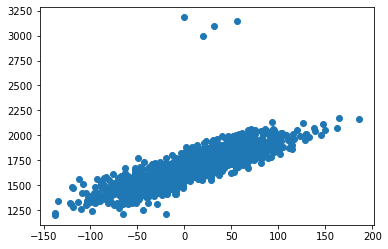

In [12]:
# Home team results
plt.scatter(df_match_fantasy_summary['match_result_home_margin'], df_match_fantasy_summary['SC_Home'])
plt.show()

In [13]:
sc_series = df_match_fantasy_summary['sc_correct?'].value_counts()
af_series = df_match_fantasy_summary['af_correct?'].value_counts()
data_dict = {
    'sc_correct?': sc_series,
    'af_correct?': af_series
}
df_fantasy_accuracy = pd.DataFrame(data_dict).transpose()
df_fantasy_accuracy['Total'] = df_fantasy_accuracy[True] + df_fantasy_accuracy[False] 
df_fantasy_accuracy['% Correct'] = round((df_fantasy_accuracy[True] / df_fantasy_accuracy['Total']) * 100, 2)
df_fantasy_accuracy

,True,False,Total,% Correct
sc_correct?,1783,254,2037,87.53
af_correct?,1607,430,2037,78.89


### Supercoach is the most accurate measure of indicating wins

In [14]:
from sklearn import linear_model
from sklearn import model_selection

X = df_match_fantasy_summary['SC_Home']
X = np.array(X).reshape(-1, 1)
y = df_match_fantasy_summary['match_result_home_margin']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.30)

clr = linear_model.LinearRegression()

cv_result = model_selection.cross_val_score(estimator=clr
                                , X=X_train
                                , y=y_train
                                , cv=50
                                , scoring="neg_mean_squared_error"
                                )

cv_result.mean()

-738.9443487155845

In [15]:
from sklearn import metrics

clr.fit(X_train, y_train)
pred = clr.predict(X_test)
sc_mse = metrics.mean_squared_error(pred, y_test)

In [16]:
from sklearn import linear_model
from sklearn import model_selection

X = df_match_fantasy_summary['AF_Home']
X = np.array(X).reshape(-1, 1)
y = df_match_fantasy_summary['match_result_home_margin']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.30)

clr = linear_model.LinearRegression()

cv_result = model_selection.cross_val_score(estimator=clr
                                , X=X_train
                                , y=y_train
                                , cv=50
                                , scoring="neg_mean_squared_error"
                                )

cv_result.mean()

-1181.558357521305

In [17]:
from sklearn import metrics

clr.fit(X_train, y_train)
pred = clr.predict(X_test)
af_mse = metrics.mean_squared_error(pred, y_test)

In [18]:
{
    "Supercoach Mean Squared Error": round(sc_mse, 1),
    "AFL Fantasy Mean Squared Error": round(af_mse, 1)
}

{'Supercoach Mean Squared Error': 587.4,
 'AFL Fantasy Mean Squared Error': 1298.8}

### Supercoach score is a more reliable indicator of the winning/losing margin

### Supercoach Player Projections

In [19]:
df_footywire_data

,Date,Season,Round,Venue,Player,Team,Opposition,Status,Match_id,CP,UP,ED,DE,CM,GA,MI5,One.Percenters,BO,TOG,K,HB,D,M,G,B,T,HO,GA1,I50,CL,CG,R50,FF,FA,AF,SC,CCL,SCL,SI,MG,TO,ITC,T5,short_round,season_team_name_id,Player ID,year_round_player_id,Injured
0,2010-03-25,2010,Round 1,MCG,Daniel Connors,Richmond,Carlton,Home,5089,8,15,16,66.7,0,0,0,1,0,69,14,10,24,3,0,0,1,0,0,2,2,4,6,2,0,77,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Daniel Connors,260105,2010_R1_260105,NaN
1,2010-03-25,2010,Round 1,MCG,Daniel Jackson,Richmond,Carlton,Home,5089,11,10,14,60.9,1,0,0,0,0,80,11,12,23,2,0,0,5,0,0,8,5,4,1,2,0,85,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Daniel Jackson,240707,2010_R1_240707,NaN
2,2010-03-25,2010,Round 1,MCG,Brett Deledio,Richmond,Carlton,Home,5089,7,14,16,76.2,0,0,0,0,0,89,12,9,21,5,1,0,6,0,0,4,3,4,3,1,2,94,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Brett Deledio,240336,2010_R1_240336,NaN
3,2010-03-25,2010,Round 1,MCG,Ben Cousins,Richmond,Carlton,Home,5089,9,10,11,57.9,0,1,0,0,0,69,13,6,19,1,1,0,1,0,1,1,2,3,4,1,0,65,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Ben Cousins,960662,2010_R1_960662,NaN
4,2010-03-25,2010,Round 1,MCG,Trent Cotchin,Richmond,Carlton,Home,5089,8,10,13,68.4,1,0,0,0,1,77,11,8,19,6,0,0,1,0,0,2,3,3,2,0,2,65,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Trent Cotchin,270896,2010_R1_270896,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89782,2019-09-28,2019,Grand Final,MCG,Harrison Himmelberg,GWS,Richmond,Away,9927,3,9,7,58.3,1,0,2,4,0,92,9,3,12,7,1,1,1,2,0,2,0,3,0,1,1,65,51,0.0,0.0,3.0,153.0,4.0,2.0,1.0,GF,2019_GWS_Harrison Himmelberg,993107,2019_GF_993107,False
89783,2019-09-28,2019,Grand Final,MCG,Samuel Reid,GWS,Richmond,Away,9927,5,6,8,66.7,0,0,0,4,0,96,5,7,12,2,0,0,3,0,0,0,1,2,1,0,0,47,55,0.0,1.0,1.0,97.0,2.0,5.0,0.0,GF,2019_GWS_Samuel Reid,261374,2019_GF_261374,False
89784,2019-09-28,2019,Grand Final,MCG,Adam Kennedy,GWS,Richmond,Away,9927,4,8,9,81.8,0,0,0,1,0,71,5,6,11,4,0,0,4,0,0,2,1,0,0,1,0,56,55,0.0,1.0,1.0,121.0,0.0,5.0,1.0,GF,2019_GWS_Adam Kennedy,291509,2019_GF_291509,False
89785,2019-09-28,2019,Grand Final,MCG,Shane Mumford,GWS,Richmond,Away,9927,8,2,7,70.0,0,0,0,4,0,75,2,8,10,0,0,0,1,15,0,1,2,2,1,1,0,42,62,1.0,1.0,0.0,0.0,1.0,2.0,0.0,GF,2019_GWS_Shane Mumford,280762,2019_GF_280762,False


In [20]:
# Get rolling averages
def rolling_average(df, window):
    return df.rolling(min_periods=1, window=window).mean().shift(1)

rolling_stat_list = ['CP', 'UP', 'ED', 'DE', 'CM', 'GA', 'MI5', 'One.Percenters', 'BO', 'TOG', 'K', 'HB', 'D', 'M', 'G', 'B', 'T', 'HO', 'GA1', 'I50', 'CL', 'CG', 'R50', 'FF', 'FA']

for stat in rolling_stat_list:
    df_footywire_data["3_rd_rolling_{}".format(stat)] = df_footywire_data.groupby('Player')[stat].apply(lambda player: rolling_average(player, 3))

df_footywire_data['rolling 20 round average'] = df_footywire_data.groupby('Player')['SC'].apply(lambda player: rolling_average(player, 20))
df_footywire_data['rolling 10 round average'] = df_footywire_data.groupby('Player')['SC'].apply(lambda player: rolling_average(player, 10))
df_footywire_data['rolling 5 round average'] = df_footywire_data.groupby('Player')['SC'].apply(lambda player: rolling_average(player, 5))
df_footywire_data['rolling 3 round average'] = df_footywire_data.groupby('Player')['SC'].apply(lambda player: rolling_average(player, 3))
df_footywire_data['previous sc score'] = df_footywire_data.groupby('Player')['SC'].apply(lambda player: rolling_average(player, 1))
df_footywire_data
df_footywire_data.loc[df_footywire_data['Player'] == 'Patrick Cripps', :]

,Date,Season,Round,Venue,Player,Team,Opposition,Status,Match_id,CP,UP,ED,DE,CM,GA,MI5,One.Percenters,BO,TOG,K,HB,D,M,G,B,T,HO,GA1,I50,CL,CG,R50,FF,FA,AF,SC,CCL,SCL,SI,MG,TO,ITC,T5,short_round,season_team_name_id,Player ID,year_round_player_id,Injured,3_rd_rolling_CP,3_rd_rolling_UP,3_rd_rolling_ED,3_rd_rolling_DE,3_rd_rolling_CM,3_rd_rolling_GA,3_rd_rolling_MI5,3_rd_rolling_One.Percenters,3_rd_rolling_BO,3_rd_rolling_TOG,3_rd_rolling_K,3_rd_rolling_HB,3_rd_rolling_D,3_rd_rolling_M,3_rd_rolling_G,3_rd_rolling_B,3_rd_rolling_T,3_rd_rolling_HO,3_rd_rolling_GA1,3_rd_rolling_I50,3_rd_rolling_CL,3_rd_rolling_CG,3_rd_rolling_R50,3_rd_rolling_FF,3_rd_rolling_FA,rolling 20 round average,rolling 10 round average,rolling 5 round average,rolling 3 round average,previous sc score
36425,2014-04-12,2014,Round 4,MCG,Patrick Cripps,Carlton,Melbourne,Home,5785,8,10,11,64.7,0,0,0,5,4,81,5,12,17,3,0,1,5,0,0,2,1,3,1,1,3,61,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R4,2014_Carlton_Patrick Cripps,990704,2014_R4_990704,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37116,2014-04-20,2014,Round 5,Etihad Stadium,Patrick Cripps,Carlton,Western Bulldogs,Away,5800,5,2,2,28.6,0,0,0,1,0,56,4,3,7,1,0,0,1,0,0,1,0,1,0,1,0,26,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R5,2014_Carlton_Patrick Cripps,990704,2014_R5_990704,False,8.000000,10.000000,11.000000,64.700000,0.000000,0.000000,0.0,5.000000,4.000000,81.000000,5.000000,12.000000,17.000000,3.000000,0.000000,1.000000,5.000000,0.000000,0.000000,2.000000,1.000000,3.000000,1.000000,1.000000,3.000000,74.000000,74.000000,74.000000,74.000000,74.0
43564,2014-08-30,2014,Round 23,MCG,Patrick Cripps,Carlton,Essendon,Home,5947,0,3,2,66.7,0,0,0,0,0,18,1,2,3,1,0,0,3,0,0,0,0,0,1,0,0,22,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R23,2014_Carlton_Patrick Cripps,990704,2014_R23_990704,False,6.500000,6.000000,6.500000,46.650000,0.000000,0.000000,0.0,3.000000,2.000000,68.500000,4.500000,7.500000,12.000000,2.000000,0.000000,0.500000,3.000000,0.000000,0.000000,1.500000,0.500000,2.000000,0.500000,1.000000,1.500000,47.500000,47.500000,47.500000,47.500000,21.0
44303,2015-04-02,2015,Round 1,MCG,Patrick Cripps,Carlton,Richmond,Home,5964,5,9,9,64.3,1,0,0,0,0,76,4,10,14,3,0,0,3,1,0,1,1,0,2,0,0,54,53,0.0,1.0,2.0,16.0,3.0,1.0,0.0,R1,2015_Carlton_Patrick Cripps,990704,2015_R1_990704,False,4.333333,5.000000,5.000000,53.333333,0.000000,0.000000,0.0,2.000000,1.333333,51.666667,3.333333,5.666667,9.000000,1.666667,0.000000,0.333333,3.000000,0.000000,0.000000,1.000000,0.333333,1.333333,0.666667,0.666667,1.000000,39.333333,39.333333,39.333333,39.333333,23.0
45130,2015-04-18,2015,Round 3,MCG,Patrick Cripps,Carlton,Essendon,Home,5983,15,7,11,50.0,1,0,0,1,0,75,10,12,22,2,0,2,4,2,0,6,5,2,0,1,0,81,89,2.0,3.0,8.0,278.0,5.0,4.0,1.0,R3,2015_Carlton_Patrick Cripps,990704,2015_R3_990704,False,3.333333,4.666667,4.333333,53.200000,0.333333,0.000000,0.0,0.333333,0.000000,50.000000,3.000000,5.000000,8.000000,1.666667,0.000000,0.000000,2.333333,0.333333,0.000000,0.666667,0.333333,0.333333,1.000000,0.333333,0.000000,42.750000,42.750000,42.750000,32.333333,53.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87499,2019-07-27,2019,Round 19,MCG,Patrick Cripps,Carlton,Adelaide,Home,9876,24,15,26,66.7,0,1,0,0,0,89,16,23,39,4,1,0,7,0,1,8,19,4,2,4,1,141,152,8.0,11.0,8.0,342.0,6.0,1.0,1.0,R19,2019_Carlton_Patrick Cripps,990704,2019_R19_990704,False,13.666667,9.666667,16.666667,75.933333,0.000000,0.000000,0.0,1.666667,1.000000,87.666667,6.333333,16.333333,22.666667,1.666667,0.333333,0.666667,5.000000,0.000000,0.000000,3.000000,6.666667,4.333333,0.000000,1.666667,3.000000,118.300000,106.700000,109.800000,88.666667,73.0
88118,2019-08-04,2019,Round 20,Marvel Stadium,Pat

In [21]:
# Get home/away status
status_dummies = pd.get_dummies(df_footywire_data['Status'], prefix='Status')
df_footywire_data = df_footywire_data.merge(status_dummies, left_index=True, right_index=True)
df_footywire_data

,Date,Season,Round,Venue,Player,Team,Opposition,Status,Match_id,CP,UP,ED,DE,CM,GA,MI5,One.Percenters,BO,TOG,K,HB,D,M,G,B,T,HO,GA1,I50,CL,CG,R50,FF,FA,AF,SC,CCL,SCL,SI,MG,TO,ITC,T5,short_round,season_team_name_id,Player ID,year_round_player_id,Injured,3_rd_rolling_CP,3_rd_rolling_UP,3_rd_rolling_ED,3_rd_rolling_DE,3_rd_rolling_CM,3_rd_rolling_GA,3_rd_rolling_MI5,3_rd_rolling_One.Percenters,3_rd_rolling_BO,3_rd_rolling_TOG,3_rd_rolling_K,3_rd_rolling_HB,3_rd_rolling_D,3_rd_rolling_M,3_rd_rolling_G,3_rd_rolling_B,3_rd_rolling_T,3_rd_rolling_HO,3_rd_rolling_GA1,3_rd_rolling_I50,3_rd_rolling_CL,3_rd_rolling_CG,3_rd_rolling_R50,3_rd_rolling_FF,3_rd_rolling_FA,rolling 20 round average,rolling 10 round average,rolling 5 round average,rolling 3 round average,previous sc score,Status_Away,Status_Home
0,2010-03-25,2010,Round 1,MCG,Daniel Connors,Richmond,Carlton,Home,5089,8,15,16,66.7,0,0,0,1,0,69,14,10,24,3,0,0,1,0,0,2,2,4,6,2,0,77,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Daniel Connors,260105,2010_R1_260105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
1,2010-03-25,2010,Round 1,MCG,Daniel Jackson,Richmond,Carlton,Home,5089,11,10,14,60.9,1,0,0,0,0,80,11,12,23,2,0,0,5,0,0,8,5,4,1,2,0,85,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Daniel Jackson,240707,2010_R1_240707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
2,2010-03-25,2010,Round 1,MCG,Brett Deledio,Richmond,Carlton,Home,5089,7,14,16,76.2,0,0,0,0,0,89,12,9,21,5,1,0,6,0,0,4,3,4,3,1,2,94,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Brett Deledio,240336,2010_R1_240336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
3,2010-03-25,2010,Round 1,MCG,Ben Cousins,Richmond,Carlton,Home,5089,9,10,11,57.9,0,1,0,0,0,69,13,6,19,1,1,0,1,0,1,1,2,3,4,1,0,65,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Ben Cousins,960662,2010_R1_960662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
4,2010-03-25,2010,Round 1,MCG,Trent Cotchin,Richmond,Carlton,Home,5089,8,10,13,68.4,1,0,0,0,1,77,11,8,19,6,0,0,1,0,0,2,3,3,2,0,2,65,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Trent Cotchin,270896,2010_R1_270896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89782,2019-09-28,2019,Grand Final,MCG,Harrison Himmelberg,GWS,Richmond,Away,9927,3,9,7,58.3,1,0,2,4,0,92,9,3,12,7,1,1,1,2,0,2,0,3,0,1,1,65,51,0.0,0.0,3.0,153.0,4.0,2.0,1.0,GF,2019_GWS_Harrison Himmelberg,993107,2019_GF_993107,False,6.333333,3.666667,7.666667,85.500000,0.000000,0.333333,0.666667,3.000000,0.000000,84.333333,3.666667,5.333333,9.000000,1.333333,0.666667,0.333333,2.333333,0.333333,0.333333,1.333333,0.666667,1.000000,0.000000,1.000000,0.666667,74.00,70.6,55.2,57.666667,58.0,1,0
89783,2019-09-28,2019,Grand Final,MCG,Samuel Reid,GWS,Richmond,Away,9927,5,6,8,66.7,0,0,0,4,0,96,5,7,12,2,0,0,3,0,0,0,1,2,1,0,0,47,55,0.0,1.0,1.0,97.0,2.0,5.0,0.0,GF,2019_GWS_Samuel Reid,261374,2019_GF_261374,False,4.000000,6.666667,8.666667,82.066667,0.000000,0.000000,0.333333,2.000000,0.000000,86.000000,5.333333,5.333333,10.666667,1.333333,0.000000,0.333333,3.000000,0.000000,0.000000,1.666667,1.333333,2.000000,0.000000,0.333333,1.333333,66.15,61.2,44.8,45.000000,55.0,1,0
89784,2019-09-28,2019,Grand Final,MCG,Adam Kennedy,GWS,Richmond,Away,9927,4,8,9,81.8,0,0,0,1,0,71,5,6,11,4,0,0,4,0,0,2,1,0,0,1,0,56,55,0.0,1.0,1.0,121.0,0.0,5.0,1.0,GF,2019_GWS_Ad

In [22]:
df_footywire_data['opposition_match_identifier'] = df_footywire_data['Match_id'].astype(str) + '_' + df_footywire_data['Opposition']
df_footywire_data

,Date,Season,Round,Venue,Player,Team,Opposition,Status,Match_id,CP,UP,ED,DE,CM,GA,MI5,One.Percenters,BO,TOG,K,HB,D,M,G,B,T,HO,GA1,I50,CL,CG,R50,FF,FA,AF,SC,CCL,SCL,SI,MG,TO,ITC,T5,short_round,season_team_name_id,Player ID,year_round_player_id,Injured,3_rd_rolling_CP,3_rd_rolling_UP,3_rd_rolling_ED,3_rd_rolling_DE,3_rd_rolling_CM,3_rd_rolling_GA,3_rd_rolling_MI5,3_rd_rolling_One.Percenters,3_rd_rolling_BO,3_rd_rolling_TOG,3_rd_rolling_K,3_rd_rolling_HB,3_rd_rolling_D,3_rd_rolling_M,3_rd_rolling_G,3_rd_rolling_B,3_rd_rolling_T,3_rd_rolling_HO,3_rd_rolling_GA1,3_rd_rolling_I50,3_rd_rolling_CL,3_rd_rolling_CG,3_rd_rolling_R50,3_rd_rolling_FF,3_rd_rolling_FA,rolling 20 round average,rolling 10 round average,rolling 5 round average,rolling 3 round average,previous sc score,Status_Away,Status_Home,opposition_match_identifier
0,2010-03-25,2010,Round 1,MCG,Daniel Connors,Richmond,Carlton,Home,5089,8,15,16,66.7,0,0,0,1,0,69,14,10,24,3,0,0,1,0,0,2,2,4,6,2,0,77,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Daniel Connors,260105,2010_R1_260105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,5089_Carlton
1,2010-03-25,2010,Round 1,MCG,Daniel Jackson,Richmond,Carlton,Home,5089,11,10,14,60.9,1,0,0,0,0,80,11,12,23,2,0,0,5,0,0,8,5,4,1,2,0,85,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Daniel Jackson,240707,2010_R1_240707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,5089_Carlton
2,2010-03-25,2010,Round 1,MCG,Brett Deledio,Richmond,Carlton,Home,5089,7,14,16,76.2,0,0,0,0,0,89,12,9,21,5,1,0,6,0,0,4,3,4,3,1,2,94,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Brett Deledio,240336,2010_R1_240336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,5089_Carlton
3,2010-03-25,2010,Round 1,MCG,Ben Cousins,Richmond,Carlton,Home,5089,9,10,11,57.9,0,1,0,0,0,69,13,6,19,1,1,0,1,0,1,1,2,3,4,1,0,65,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Ben Cousins,960662,2010_R1_960662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,5089_Carlton
4,2010-03-25,2010,Round 1,MCG,Trent Cotchin,Richmond,Carlton,Home,5089,8,10,13,68.4,1,0,0,0,1,77,11,8,19,6,0,0,1,0,0,2,3,3,2,0,2,65,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Trent Cotchin,270896,2010_R1_270896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,5089_Carlton
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89782,2019-09-28,2019,Grand Final,MCG,Harrison Himmelberg,GWS,Richmond,Away,9927,3,9,7,58.3,1,0,2,4,0,92,9,3,12,7,1,1,1,2,0,2,0,3,0,1,1,65,51,0.0,0.0,3.0,153.0,4.0,2.0,1.0,GF,2019_GWS_Harrison Himmelberg,993107,2019_GF_993107,False,6.333333,3.666667,7.666667,85.500000,0.000000,0.333333,0.666667,3.000000,0.000000,84.333333,3.666667,5.333333,9.000000,1.333333,0.666667,0.333333,2.333333,0.333333,0.333333,1.333333,0.666667,1.000000,0.000000,1.000000,0.666667,74.00,70.6,55.2,57.666667,58.0,1,0,9927_Richmond
89783,2019-09-28,2019,Grand Final,MCG,Samuel Reid,GWS,Richmond,Away,9927,5,6,8,66.7,0,0,0,4,0,96,5,7,12,2,0,0,3,0,0,0,1,2,1,0,0,47,55,0.0,1.0,1.0,97.0,2.0,5.0,0.0,GF,2019_GWS_Samuel Reid,261374,2019_GF_261374,False,4.000000,6.666667,8.666667,82.066667,0.000000,0.000000,0.333333,2.000000,0.000000,86.000000,5.333333,5.333333,10.666667,1.333333,0.000000,0.333333,3.000000,0.000000,0.000000,1.666667,1.333333,2.000000,0.000000,0.333333,1.333333,66.15,61.2,44.8,45.000000,55.0,1,0,9927_Richmond
89784,2019-09-28,2019,Grand Final,MCG,Adam Kennedy,GWS

In [23]:
# Get rolling previous team SC scores
renamed_cols = {
    "home_team": "team", 
    "home_team_score": "score",
    "AF_Home": "AF", 
    "SC_Home": "SC", 
    "match_result_home_margin": "margin", 
    "away_team": "team", 
    "away_team_score": "score", 
    "AF_Away": "AF", 
    "SC_Away": "SC", 
    "match_result_away_margin": "margin"
}

home_match_details = df_match_fantasy_summary.loc[:, ['year', 'date', 'venue', 'crowd', 'match_id', 'home_team', 'home_team_score', 'AF_Home', 'SC_Home', 'match_result_home_margin']].rename(columns=renamed_cols)
away_match_details = df_match_fantasy_summary.loc[:, ['year', 'date', 'venue', 'crowd', 'match_id', 'away_team', 'away_team_score', 'AF_Away', 'SC_Away', 'match_result_away_margin']].rename(columns=renamed_cols)
df_matches_by_team = pd.concat([home_match_details, away_match_details]).sort_index().reset_index()
df_matches_by_team['opposition previous SC match score'] =  df_matches_by_team.groupby('team')['SC'].apply(lambda team: rolling_average(team, 1))
df_matches_by_team['opposition rolling 3 round SC match average'] =  df_matches_by_team.groupby('team')['SC'].apply(lambda team: rolling_average(team, 3))
df_matches_by_team['opposition rolling 5 round SC match average'] =  df_matches_by_team.groupby('team')['SC'].apply(lambda team: rolling_average(team, 5))
df_matches_by_team['match_identifier'] = df_matches_by_team['match_id'].astype(str) + '_' + df_matches_by_team['team']
df_matches_by_team

,index,year,date,venue,crowd,match_id,team,score,AF,SC,margin,opposition previous SC match score,opposition rolling 3 round SC match average,opposition rolling 5 round SC match average,match_identifier
0,0,2010,Thu 25 Mar 7:10pm,MCG,72010,5089,Richmond,64,1250,1321,-56,NaN,NaN,NaN,5089_Richmond
1,0,2010,Thu 25 Mar 7:10pm,MCG,72010,5089,Carlton,120,1938,1986,56,NaN,NaN,NaN,5089_Carlton
2,1,2010,Fri 26 Mar 7:40pm,MCG,57772,5090,Geelong,125,1774,1775,31,NaN,NaN,NaN,5090_Geelong
3,1,2010,Fri 26 Mar 7:40pm,MCG,57772,5090,Essendon,94,1503,1523,-31,NaN,NaN,NaN,5090_Essendon
4,2,2010,Sat 27 Mar 2:10pm,MCG,45615,5091,Melbourne,61,1516,1470,-56,NaN,NaN,NaN,5091_Melbourne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4069,2034,2019,Fri 20 Sep 7:50pm,MCG,94423,9925,Richmond,85,1385,1616,19,1622.0,1671.333333,1700.2,9925_Richmond
4070,2035,2019,Sat 21 Sep 4:35pm,MCG,77828,9926,GWS,56,1518,1657,4,1622.0,1757.000000,1675.8,9926_GWS
4071,2035,2019,Sat 21 Sep 4:35pm,MCG,77828,9926,Collingwood,52,1580,1641,-4,1807.0,1807.666667,1826.6,9926_Collingwood
4072,2036,2019,Sat 28 Sep 2:30pm,MCG,100014,9927,Richmond,114,1632,1773,89,1616.0,1635.000000,1679.8,9927_Richmond


In [24]:
df_footywire_data = pd.merge(
    df_footywire_data, 
    df_matches_by_team, 
    how='left',
    left_on='opposition_match_identifier', 
    right_on='match_identifier', 
    suffixes=('', '_match')
)
df_footywire_data

,Date,Season,Round,Venue,Player,Team,Opposition,Status,Match_id,CP,UP,ED,DE,CM,GA,MI5,One.Percenters,BO,TOG,K,HB,D,M,G,B,T,HO,GA1,I50,CL,CG,R50,FF,FA,AF,SC,CCL,SCL,SI,MG,TO,ITC,T5,short_round,season_team_name_id,Player ID,year_round_player_id,Injured,3_rd_rolling_CP,3_rd_rolling_UP,3_rd_rolling_ED,3_rd_rolling_DE,3_rd_rolling_CM,3_rd_rolling_GA,3_rd_rolling_MI5,3_rd_rolling_One.Percenters,3_rd_rolling_BO,3_rd_rolling_TOG,3_rd_rolling_K,3_rd_rolling_HB,3_rd_rolling_D,3_rd_rolling_M,3_rd_rolling_G,3_rd_rolling_B,3_rd_rolling_T,3_rd_rolling_HO,3_rd_rolling_GA1,3_rd_rolling_I50,3_rd_rolling_CL,3_rd_rolling_CG,3_rd_rolling_R50,3_rd_rolling_FF,3_rd_rolling_FA,rolling 20 round average,rolling 10 round average,rolling 5 round average,rolling 3 round average,previous sc score,Status_Away,Status_Home,opposition_match_identifier,index,year,date,venue,crowd,match_id,team,score,AF_match,SC_match,margin,opposition previous SC match score,opposition rolling 3 round SC match average,opposition rolling 5 round SC match average,match_identifier
0,2010-03-25,2010,Round 1,MCG,Daniel Connors,Richmond,Carlton,Home,5089,8,15,16,66.7,0,0,0,1,0,69,14,10,24,3,0,0,1,0,0,2,2,4,6,2,0,77,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Daniel Connors,260105,2010_R1_260105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,5089_Carlton,0,2010,Thu 25 Mar 7:10pm,MCG,72010,5089,Carlton,120,1938,1986,56,NaN,NaN,NaN,5089_Carlton
1,2010-03-25,2010,Round 1,MCG,Daniel Jackson,Richmond,Carlton,Home,5089,11,10,14,60.9,1,0,0,0,0,80,11,12,23,2,0,0,5,0,0,8,5,4,1,2,0,85,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Daniel Jackson,240707,2010_R1_240707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,5089_Carlton,0,2010,Thu 25 Mar 7:10pm,MCG,72010,5089,Carlton,120,1938,1986,56,NaN,NaN,NaN,5089_Carlton
2,2010-03-25,2010,Round 1,MCG,Brett Deledio,Richmond,Carlton,Home,5089,7,14,16,76.2,0,0,0,0,0,89,12,9,21,5,1,0,6,0,0,4,3,4,3,1,2,94,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Brett Deledio,240336,2010_R1_240336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,5089_Carlton,0,2010,Thu 25 Mar 7:10pm,MCG,72010,5089,Carlton,120,1938,1986,56,NaN,NaN,NaN,5089_Carlton
3,2010-03-25,2010,Round 1,MCG,Ben Cousins,Richmond,Carlton,Home,5089,9,10,11,57.9,0,1,0,0,0,69,13,6,19,1,1,0,1,0,1,1,2,3,4,1,0,65,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Ben Cousins,960662,2010_R1_960662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,5089_Carlton,0,2010,Thu 25 Mar 7:10pm,MCG,72010,5089,Carlton,120,1938,1986,56,NaN,NaN,NaN,5089_Carlton
4,2010-03-25,2010,Round 1,MCG,Trent Cotchin,Richmond,Carlton,Home,5089,8,10,13,68.4,1,0,0,0,1,77,11,8,19,6,0,0,1,0,0,2,3,3,2,0,2,65,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Trent Cotchin,270896,2010_R1_270896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,5089_Carlton,0,2010,Thu 25 Mar 7:10pm,MCG,72010,5089,Carlton,120,1938,1986,56,NaN,NaN,NaN,5089_Carlton
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89782,2019-09-28,2019,Grand Final,MCG,Harrison Himmelberg,GWS,Richmond,Away,9927,3,9,7,58.3,1,0,2,4,0,92,9,3,12,7,1,1,1,2,0,2,0,3,0,1,1,65,51,0.0,0.0,3.0,153.0,4.0,2.0,1.0,GF,2019_GWS_Harrison Himmelberg,993107,2019_GF_993107,False,6.333333,3.666667,7.666667,85.500000,0.000000,0.333333,0.666667,3.000000,0.000000,84.333333,3.66666

In [66]:
features = [
    '3_rd_rolling_CP',
    '3_rd_rolling_UP',
    '3_rd_rolling_ED',
    '3_rd_rolling_DE',
    '3_rd_rolling_CM',
    '3_rd_rolling_GA',
    '3_rd_rolling_MI5',
    '3_rd_rolling_One.Percenters',
    '3_rd_rolling_BO',
    '3_rd_rolling_TOG',
    '3_rd_rolling_K',
    '3_rd_rolling_HB',
    '3_rd_rolling_D',
    '3_rd_rolling_M',
    '3_rd_rolling_G',
    '3_rd_rolling_B',
    '3_rd_rolling_T',
    '3_rd_rolling_HO',
    '3_rd_rolling_GA1',
    '3_rd_rolling_I50',
    '3_rd_rolling_CL',
    '3_rd_rolling_CG',
    '3_rd_rolling_R50',
    '3_rd_rolling_FF',
    '3_rd_rolling_FA',
    'rolling 20 round average',
    'rolling 10 round average',
    'rolling 5 round average',
    'rolling 3 round average',
    'previous sc score',
    'rolling 3 round average', 
    'previous sc score', 
    'Status_Away',
    'Status_Home',
    'opposition previous SC match score',
    'opposition rolling 3 round SC match average',
    'opposition rolling 5 round SC match average',
    'Injured'
]
target = "SC"
df_footywire_data_clean = df_footywire_data.dropna(subset=features+[target])

X = df_footywire_data_clean.loc[:, features]
y = df_footywire_data_clean[target]

from sklearn import model_selection

# train/test split
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.30)

In [67]:
from sklearn import ensemble
from sklearn import linear_model
from sklearn import svm

# clr = ensemble.RandomForestClassifier()
# clr = ensemble.GradientBoostingClassifier()
# clr = svm.SVR()
# clr = linear_model.ElasticNet()
clr = linear_model.BayesianRidge()
# clr = linear_model.Lasso()
# clr = linear_model.LinearRegression()
# clr = linear_model.LassoLars()
# clr = linear_model.LogisticRegression()


In [68]:
cv_result = model_selection.cross_validate(estimator=clr
                                , X=X_train
                                , y=y_train
                                , cv=10
                                , scoring=["neg_mean_squared_error"]
                                )
cv_result['test_neg_mean_squared_error'].mean()

-583.0677836553333

In [69]:
clr.fit(X_train, y_train)

pred = clr.predict(X_test)

In [70]:
evaluate = pd.DataFrame({
    "actual": y_test,
    "predicted": pred,
    "diff": y_test - pred
})

# evaluate
df_predicted_scores = pd.merge(df_footywire_data_clean, evaluate, left_index=True, right_index=True)
df_predicted_scores

,Date,Season,Round,Venue,Player,Team,Opposition,Status,Match_id,CP,UP,ED,DE,CM,GA,MI5,One.Percenters,BO,TOG,K,HB,D,M,G,B,T,HO,GA1,I50,CL,CG,R50,FF,FA,AF,SC,CCL,SCL,SI,MG,TO,ITC,T5,short_round,season_team_name_id,Player ID,year_round_player_id,Injured,3_rd_rolling_CP,3_rd_rolling_UP,3_rd_rolling_ED,3_rd_rolling_DE,3_rd_rolling_CM,3_rd_rolling_GA,3_rd_rolling_MI5,3_rd_rolling_One.Percenters,3_rd_rolling_BO,3_rd_rolling_TOG,3_rd_rolling_K,3_rd_rolling_HB,3_rd_rolling_D,3_rd_rolling_M,3_rd_rolling_G,3_rd_rolling_B,3_rd_rolling_T,3_rd_rolling_HO,3_rd_rolling_GA1,3_rd_rolling_I50,3_rd_rolling_CL,3_rd_rolling_CG,3_rd_rolling_R50,3_rd_rolling_FF,3_rd_rolling_FA,rolling 20 round average,rolling 10 round average,rolling 5 round average,rolling 3 round average,previous sc score,Status_Away,Status_Home,opposition_match_identifier,index,year,date,venue,crowd,match_id,team,score,AF_match,SC_match,margin,opposition previous SC match score,opposition rolling 3 round SC match average,opposition rolling 5 round SC match average,match_identifier,actual,predicted,diff
1057,2010-04-16,2010,Round 4,Domain Stadium,Andrew Embley,West Coast,Essendon,Home,5065,10,16,13,46.4,0,0,0,0,0,83,20,8,28,1,1,0,6,1,0,6,6,4,2,1,0,111,98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R4,2010_West Coast_Andrew Embley,990020,2010_R4_990020,False,7.000000,18.000000,16.666667,68.600000,0.333333,0.666667,0.333333,2.666667,0.333333,89.333333,14.666667,9.666667,24.333333,7.333333,0.333333,0.666667,3.000000,0.000000,0.666667,5.333333,1.666667,3.000000,1.666667,0.666667,0.666667,90.333333,90.333333,90.333333,90.333333,78.0,0,1,5065_Essendon,24,2010,Fri 16 Apr 6:40pm,Domain Stadium,38676,5065,Essendon,78,1479,1550,-23,1828.0,1671.666667,1671.666667,5065_Essendon,98,89.762814,8.237186
1059,2010-04-16,2010,Round 4,Domain Stadium,Brad Ebert,West Coast,Essendon,Home,5065,8,13,15,71.4,0,0,0,4,0,81,12,9,21,3,1,0,6,0,0,1,2,1,2,1,0,94,112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R4,2010_West Coast_Brad Ebert,261911,2010_R4_261911,False,5.000000,17.333333,13.333333,58.300000,0.333333,1.000000,0.000000,0.333333,0.666667,83.333333,15.333333,7.333333,22.666667,6.333333,0.666667,0.666667,4.666667,0.000000,1.000000,3.666667,1.000000,3.333333,1.333333,0.666667,1.000000,74.000000,74.000000,74.000000,74.000000,97.0,0,1,5065_Essendon,24,2010,Fri 16 Apr 6:40pm,Domain Stadium,38676,5065,Essendon,78,1479,1550,-23,1828.0,1671.666667,1671.666667,5065_Essendon,112,79.635162,32.364838
1060,2010-04-16,2010,Round 4,Domain Stadium,Dean Cox,West Coast,Essendon,Home,5065,12,7,13,68.4,0,0,0,0,0,76,9,10,19,2,1,1,2,30,0,0,4,3,0,4,1,99,119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R4,2010_West Coast_Dean Cox,200112,2010_R4_200112,False,3.000000,7.000000,8.666667,86.300000,0.333333,0.333333,0.000000,0.333333,0.000000,65.000000,3.666667,6.333333,10.000000,1.333333,0.666667,0.000000,1.333333,22.333333,0.333333,2.000000,1.333333,2.000000,0.333333,1.333333,1.333333,56.666667,56.666667,56.666667,56.666667,79.0,0,1,5065_Essendon,24,2010,Fri 16 Apr 6:40pm,Domain Stadium,38676,5065,Essendon,78,1479,1550,-23,1828.0,1671.666667,1671.666667,5065_Essendon,119,66.832951,52.167049
1061,2010-04-16,2010,Round 4,Domain Stadium,Adam Selwood,West Coast,Essendon,Home,5065,9,12,11,57.9,0,0,0,1,0,75,10,9,19,4,1,0,11,0,0,2,3,3,0,3,2,107,108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R4,2010_West Coast_Adam Selwood,230254,2010_R4_230254,False,7.333333,18.666667,18.000000,67.600000,0.333333,0.000000,0.333333,2.333333,0.000000,84.666667,13.333333,13.666667,27.000000,5.666667,0.000000,0.666667,5.000000,1.000000,0.000000,3.333333,4.666667,2.666667,1.000000,1.333333,1.000000,93.333333,93.333333,93.333333,93.333333,58.0,0,1,5065_Essendon,24,2010,Fri 16 Apr 6:40pm,Domain Stadium,38676,5065,Essendon,78,1479,1550,-23,1828.0,1671.666667,1671.666667,5065_Essendon,108,95.586542,12.413458
1065,2010-04-16,2010,Round 4,Domain Stadium,Bradd Dalziell,West Coast,Essendon,Home,5065,4,11,15,93.8,0,0,0,1,1,61,6,10,16,6,0,0,4,0,0,2,0,1,2,0,0,72,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R4,2010_West Coast_Bradd Dalziell,26054

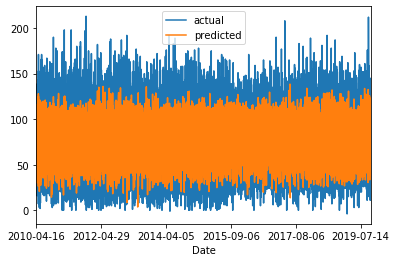

In [71]:
df_all_players_predicted = df_predicted_scores[['Date', 'actual', 'predicted']]
df_all_players_predicted = df_all_players_predicted.set_index('Date')
lines = df_all_players_predicted.plot.line()

,actual,predicted
Date,,
2010-05-23,85,71.419654
2010-05-29,70,68.031563
2010-06-05,118,71.501637
2010-06-27,63,81.408168
2010-07-10,86,76.845212
...,...,...
2019-05-18,115,104.308744
2019-07-28,99,111.277622
2019-08-03,57,113.457721


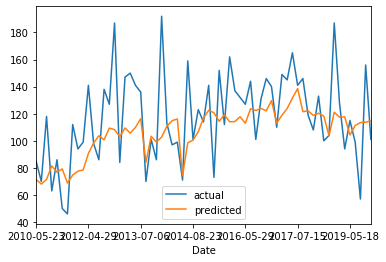

In [72]:
df_player = df_predicted_scores.loc[df_predicted_scores['Player'] == 'Patrick Dangerfield']
df_player = df_player[['Date', 'actual', 'predicted']]
df_player = df_player.set_index('Date')
display(df_player)
lines = df_player.plot.line()

In [73]:
# Is it a better predictor than simply 10, 5, 3, or 1 round average? YES

from sklearn.metrics import mean_squared_error 

display(mean_squared_error(df_predicted_scores['rolling 20 round average'], df_predicted_scores['actual']))
display(mean_squared_error(df_predicted_scores['rolling 10 round average'], df_predicted_scores['actual']))
display(mean_squared_error(df_predicted_scores['rolling 5 round average'], df_predicted_scores['actual']))
display(mean_squared_error(df_predicted_scores['rolling 3 round average'], df_predicted_scores['actual']))
display(mean_squared_error(df_predicted_scores['previous sc score'], df_predicted_scores['actual']))
display(mean_squared_error(df_predicted_scores['predicted'], df_predicted_scores['actual']))

643.0776383917203

652.2659157855563

690.6858878897114

751.4470059132352

1099.3367184774604

582.0758082563582